In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle
import torch
from data_parser import data_loader_full
import io
from matplotlib import cm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from utils import params

In [51]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)

file_path = 'Losses/loss_burnin_all.pkl'
with open(file_path, 'rb') as pickle_file:
    loss_burnin = CPU_Unpickler(pickle_file).load()

file_path = 'Losses/loss_main_all.pkl'
with open(file_path, 'rb') as pickle_file:
    loss_main = CPU_Unpickler(pickle_file).load()

file_path = 'Losses/loss_refine_all.pkl'
with open(file_path, 'rb') as pickle_file:
    loss_refine = CPU_Unpickler(pickle_file).load()

In [52]:
def moving_average(arr, window_size):
    window = np.ones(window_size) / window_size
    return np.convolve(arr, window, mode='valid')
window_size = 50

In [53]:
# burnin losses
occu_burnin = []
flow_burnin = []
speed_burnin = []
k_t_burnin = []
burnin_losses = []

In [54]:
num_epochs_burnin = params['burn_in_epoch']
for epoch_burnin in range(num_epochs_burnin):
    occu_burnin.append(loss_burnin[epoch_burnin]['occupancy'].item())
    flow_burnin.append(loss_burnin[epoch_burnin]['flow'].item())
    speed_burnin.append(loss_burnin[epoch_burnin]['speed'].item())
    k_t_burnin.append(loss_burnin[epoch_burnin]['k_t'].item())
    burnin_losses.append(params['occupancy_weight']*(loss_burnin[epoch_burnin]['occupancy'].item())\
                  +params['flow_weight']*(loss_burnin[epoch_burnin]['flow'].item())\
                  +params['speed_weight']*(loss_burnin[epoch_burnin]['speed'].item())\
                  +params['k_t_weight']*(loss_burnin[epoch_burnin]['k_t'].item()))

In [55]:
occu_burnin = moving_average(occu_burnin, window_size)
flow_burnin = moving_average(flow_burnin, window_size)
speed_burnin = moving_average(speed_burnin, window_size)
k_t_burnin = moving_average(k_t_burnin, window_size)
burnin_losses = moving_average(burnin_losses, window_size)

In [56]:
# main losses
occu_main = []
flow_main = []
speed_main = []
k_t_main = []
main_losses = []

In [57]:
num_epochs_main = params['num_epochs']
for epoch_main in range(num_epochs_main):
    occu_main.append(loss_main[epoch_main]['occupancy'].item())
    flow_main.append(loss_main[epoch_main]['flow'].item())
    speed_main.append(loss_main[epoch_main]['speed'].item())
    k_t_main.append(loss_main[epoch_main]['k_t'].item())
    main_losses.append(params['occupancy_weight']*(loss_main[epoch_main]['occupancy'].item())\
                  +params['flow_weight']*(loss_main[epoch_main]['flow'].item())\
                  +params['speed_weight']*(loss_main[epoch_main]['speed'].item())\
                  +params['k_t_weight']*(loss_main[epoch_main]['k_t'].item())\
                  +params['sparsity_weight'] * loss_main[epoch_main]['sparsity'])

In [58]:
occu_main = moving_average(occu_main, window_size)
flow_main = moving_average(flow_main, window_size)
speed_main = moving_average(speed_main, window_size)
k_t_main = moving_average(k_t_main, window_size)
main_losses = moving_average(main_losses, window_size)

In [59]:
# refine losses
occu_refine = []
flow_refine = []
speed_refine = []
k_t_refine = []
refine_losses = []

In [60]:
num_epochs_refine = params['refinement_epochs']
for epoch_refine in range(num_epochs_refine):
    occu_refine.append(loss_refine[epoch_refine]['occupancy'].item())
    flow_refine.append(loss_refine[epoch_refine]['flow'].item())
    speed_refine.append(loss_refine[epoch_refine]['speed'].item())
    k_t_refine.append(loss_refine[epoch_refine]['k_t'].item())
    refine_losses.append(params['occupancy_weight']*(loss_refine[epoch_refine]['occupancy'].item())\
                  +params['flow_weight']*(loss_refine[epoch_refine]['flow'].item())\
                  +params['speed_weight']*(loss_refine[epoch_refine]['speed'].item())\
                  +params['k_t_weight']*(loss_refine[epoch_refine]['k_t'].item()))

In [61]:
occu_refine = moving_average(occu_refine, window_size)
flow_refine = moving_average(flow_refine, window_size)
speed_refine = moving_average(speed_refine, window_size)
k_t_refine = moving_average(k_t_refine, window_size)
refine_losses = moving_average(refine_losses, window_size)

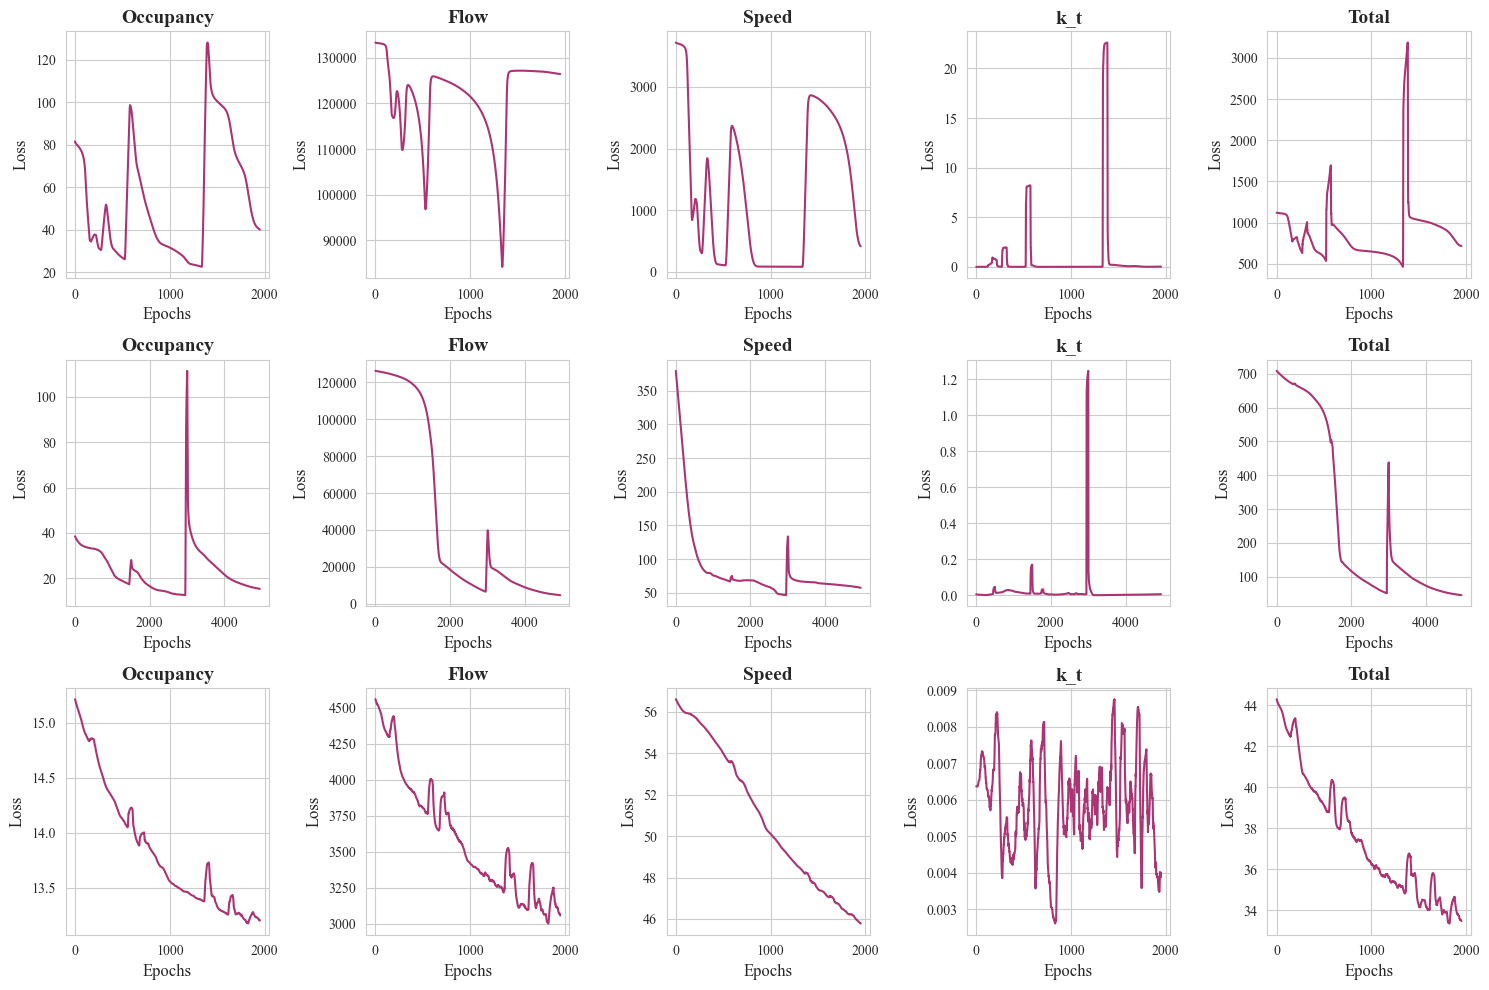

In [62]:
fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(15,10))

# burn-in
axs[0,0].plot(occu_burnin, color = '#aa3474',label = "Training")
axs[0,0].set_xlabel('Epochs', fontsize=12)
axs[0,0].set_ylabel('Loss', fontsize=12)
axs[0,0].set_title('Occupancy', fontsize=14, weight='bold')

axs[0,1].plot(flow_burnin, color = '#aa3474',label = "Training")
axs[0,1].set_xlabel('Epochs', fontsize=12)
axs[0,1].set_ylabel('Loss', fontsize=12)
axs[0,1].set_title('Flow', fontsize=14, weight='bold')

axs[0,2].plot(speed_burnin, color = '#aa3474',label = "Training")
axs[0,2].set_xlabel('Epochs', fontsize=12)
axs[0,2].set_ylabel('Loss', fontsize=12)
axs[0,2].set_title('Speed', fontsize=14, weight='bold')

axs[0,3].plot(k_t_burnin, color = '#aa3474',label = "Training")
axs[0,3].set_xlabel('Epochs', fontsize=12)
axs[0,3].set_ylabel('Loss', fontsize=12)
axs[0,3].set_title('k_t', fontsize=14, weight='bold')

axs[0,4].plot(burnin_losses, color = '#aa3474',label = "Training")
axs[0,4].set_xlabel('Epochs', fontsize=12)
axs[0,4].set_ylabel('Loss', fontsize=12)
axs[0,4].set_title('Total', fontsize=14, weight='bold')

# main loss
axs[1,0].plot(occu_main, color = '#aa3474',label = "Training")
axs[1,0].set_xlabel('Epochs', fontsize=12)
axs[1,0].set_ylabel('Loss', fontsize=12)
axs[1,0].set_title('Occupancy', fontsize=14, weight='bold')

axs[1,1].plot(flow_main, color = '#aa3474',label = "Training")
axs[1,1].set_xlabel('Epochs', fontsize=12)
axs[1,1].set_ylabel('Loss', fontsize=12)
axs[1,1].set_title('Flow', fontsize=14, weight='bold')

axs[1,2].plot(speed_main, color = '#aa3474',label = "Training")
axs[1,2].set_xlabel('Epochs', fontsize=12)
axs[1,2].set_ylabel('Loss', fontsize=12)
axs[1,2].set_title('Speed', fontsize=14, weight='bold')

axs[1,3].plot(k_t_main, color = '#aa3474',label = "Training")
axs[1,3].set_xlabel('Epochs', fontsize=12)
axs[1,3].set_ylabel('Loss', fontsize=12)
axs[1,3].set_title('k_t', fontsize=14, weight='bold')

axs[1,4].plot(main_losses, color = '#aa3474',label = "Training")
axs[1,4].set_xlabel('Epochs', fontsize=12)
axs[1,4].set_ylabel('Loss', fontsize=12)
axs[1,4].set_title('Total', fontsize=14, weight='bold')

# refinement loss
axs[2,0].plot(occu_refine, color = '#aa3474',label = "Training")
axs[2,0].set_xlabel('Epochs', fontsize=12)
axs[2,0].set_ylabel('Loss', fontsize=12)
axs[2,0].set_title('Occupancy', fontsize=14, weight='bold')

axs[2,1].plot(flow_refine, color = '#aa3474',label = "Training")
axs[2,1].set_xlabel('Epochs', fontsize=12)
axs[2,1].set_ylabel('Loss', fontsize=12)
axs[2,1].set_title('Flow', fontsize=14, weight='bold')

axs[2,2].plot(speed_refine, color = '#aa3474',label = "Training")
axs[2,2].set_xlabel('Epochs', fontsize=12)
axs[2,2].set_ylabel('Loss', fontsize=12)
axs[2,2].set_title('Speed', fontsize=14, weight='bold')

axs[2,3].plot(k_t_refine, color = '#aa3474',label = "Training")
axs[2,3].set_xlabel('Epochs', fontsize=12)
axs[2,3].set_ylabel('Loss', fontsize=12)
axs[2,3].set_title('k_t', fontsize=14, weight='bold')

axs[2,4].plot(refine_losses, color = '#aa3474',label = "Training")
axs[2,4].set_xlabel('Epochs', fontsize=12)
axs[2,4].set_ylabel('Loss', fontsize=12)
axs[2,4].set_title('Total', fontsize=14, weight='bold')

plt.tight_layout()
#plt.subplots_adjust(hspace=0.1, wspace=0.3)
plt.rcParams['font.family'] = 'Times New Roman'
plt.show()